In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features (e.g., Open, High, Low, Close, Volume)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
spy_data = spy_data[features]
spy_data['Daily_Return'] = spy_data['Close'].pct_change()
spy_data.dropna(inplace=True)

# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)

[*********************100%***********************]  1 of 1 completed

Dataset shape: (3521, 6)
[[ 1.13260002e+02  1.13680000e+02  1.12849998e+02  1.13629997e+02
   1.11579900e+08  2.64709625e-03]
 [ 1.13519997e+02  1.13989998e+02  1.13430000e+02  1.13709999e+02
   1.16074400e+08  7.04055557e-04]
 [ 1.13500000e+02  1.14330002e+02  1.13180000e+02  1.14190002e+02
   1.31091100e+08  4.22129418e-03]
 ...
 [ 4.75440002e+02  4.76660004e+02  4.74890015e+02  4.76510010e+02
   6.80003000e+07  1.80808553e-03]
 [ 4.76880005e+02  4.77549988e+02  4.76260010e+02  4.76690002e+02
   7.71581000e+07  3.77731154e-04]
 [ 4.76489990e+02  4.77029999e+02  4.73299988e+02  4.75309998e+02
   1.22234100e+08 -2.89497341e-03]]


In [4]:
data_pd=pd.DataFrame(data)
data_pd

,0,1,2,3,4,5
0,113.260002,113.680000,112.849998,113.629997,111579900.0,0.002647
1,113.519997,113.989998,113.430000,113.709999,116074400.0,0.000704
2,113.500000,114.330002,113.180000,114.190002,131091100.0,0.004221
3,113.889999,114.620003,113.660004,114.570000,126402800.0,0.003328
4,115.080002,115.129997,114.239998,114.730003,106375700.0,0.001397
...,...,...,...,...,...,...
3516,473.859985,475.380005,471.700012,473.649994,67126600.0,0.002010
3517,474.070007,476.579987,473.989990,475.649994,55387000.0,0.004223
3518,475.440002,476.660004,474.890015,476.510010,68000300.0,0.001808
3519,476.880005,477.549988,476.260010,476.690002,77158100.0,0.000378


In [ ]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    for i in range(len(data) - time_steps):
        # Extract a sequence of `time_steps` (excluding the target column)
        sequence = np.delete(data[i:i + time_steps], target_column, axis=1)
        sequences.append(sequence)

        # Extract the target value at the end of the sequence
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 30
target_column = 5  # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)

Shape of X: (3491, 30, 5)
Shape of y: (3491,)


In [ ]:
# Flatten X to shape (3491, 30*5)
X = X.reshape(X.shape[0], -1)
print("Shape of X_flattened:", X.shape)  # (3491, 150)

Shape of X_flattened: (3491, 150)


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the data
X = scaler.fit_transform(X)

In [10]:
from sklearn.model_selection import train_test_split

# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_regressor.predict(X_test)

# Calculate metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
correlation_rf = np.corrcoef(y_test, y_pred_rf)[0, 1]  # Correlation coefficient

print(f"Random Forest - Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf:.6f}")
print(f"Random Forest - Correlation Coefficient: {correlation_rf:.2f}")

Random Forest - Mean Squared Error (MSE): 0.000132
Random Forest - Mean Absolute Error (MAE): 0.008817
Random Forest - Correlation Coefficient: 0.06


In [15]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = y_pred_rf.flatten()  # Predicted returns (flattened to 1D)
y_true = y_test  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for pred_return, true_return in zip(y_pred, y_true):
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    daily_return = true_return if position == 1 else 0
    strategy_returns.append(daily_return)

    # Update cumulative return
    cumulative_return *= (1 + daily_return)

# Convert strategy returns to a DataFrame for analysis
strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage


Cumulative Return: 39.97%


In [16]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(1 + y_true) - 1  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")

True Buy-and-Hold Cumulative Return: 21.07%
Strategy Cumulative Return: 39.97%


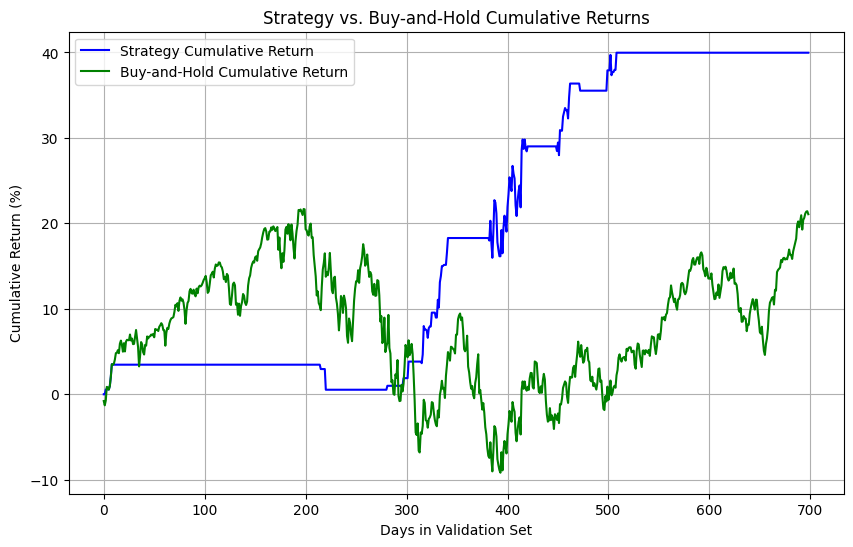

In [17]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


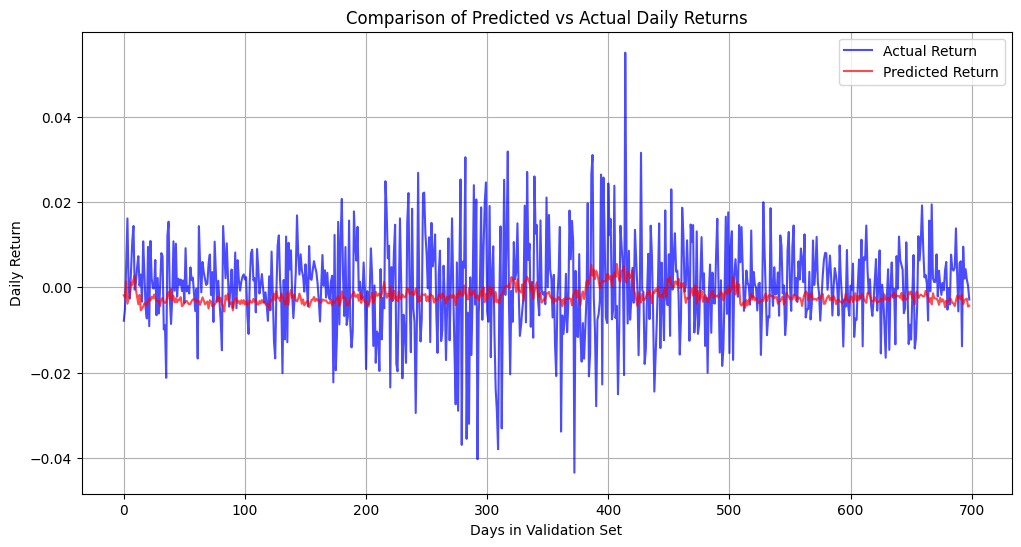

In [18]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()
